In [1]:
import math, sys
from calflops import calculate_flops
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset
from torch.utils.data import Subset

/home/da0698@unt.ad.unt.edu/anaconda3/envs/dlgpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-04 21:58:18.212889: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-04 21:58:18.264116: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 21:58:19.185812: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT 

In [2]:
LiGO_bool = True
emb_size = 128
new_emb_size = 256
block_size = 64
multi_heads = 2
batch_size = 512
epochs = 3
learning_rate = 3e-4
device = torch.device('cuda:0')
num_small_layers = 4
multi_heads = 2
batches_per_epoch = 10


In [3]:
# Dataset wikitext-2
# dataset = load_dataset('wikitext', 'wikitext-2-v1')

# Dataset wikitext-103
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# padding token 
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size = len(tokenizer)

def tokenize_function(examples):
    return tokenizer(examples['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=block_size)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, collate_fn=data_collator)


In [4]:
train_dataloader = list(train_dataloader)
val_dataloader = list(val_dataloader)

In [5]:
@torch.no_grad()
def validate(mdl, dataloader, device=device):
    loss_fn = torch.nn.CrossEntropyLoss()
    mdl.eval()
    total_loss = 0
    num_batches = 0
    ix = torch.randint(len(dataloader), tuple([5]))
    # dataloader = list(dataloader)
    for index in ix:
        batch = dataloader[index]
        inputs = batch["input_ids"].detach().clone().detach().squeeze(1).to(device)
        labels = batch["labels"].detach().clone().detach().to(device)
        outputs = mdl(inputs)
        loss = loss_fn(outputs.view(-1, vocab_size), labels.view(-1))
        total_loss += loss.item()
        num_batches += 1
        del loss
        del outputs
    return total_loss / num_batches

@torch.enable_grad()
def train(mdl, optim, epochs, train_dataloader=train_dataloader, val_dataloader=val_dataloader, device=device):
    loss_fn = torch.nn.CrossEntropyLoss()
    mdl.to(device)
    val_losses_epoch = []
    # train_dataloader = list(train_dataloader)
    for epoch in range(epochs):
        mdl.train()
        total_loss = 0
        num_batches = 0
        ix = torch.randint(len(train_dataloader), tuple([batches_per_epoch]))
        for index in ix:
            batch = train_dataloader[index]
            # print(f"Processing Batch: {index} in Epoch: {epoch}")
            inputs = batch["input_ids"].detach().clone().detach().to(device).squeeze(1)
            optim.zero_grad()
            outputs = mdl(inputs)
            labels = batch["labels"].detach().clone().detach().to(device)
            loss = loss_fn(outputs.view(-1, vocab_size), labels.view(-1))
            loss.backward()
            optim.step()
            total_loss += loss.item()
            num_batches += 1
            del loss
            del outputs
        avg_loss = total_loss / num_batches
        val_loss = validate(mdl, val_dataloader, device=device)
        val_losses_epoch.append(val_loss)
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return val_losses_epoch

In [6]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [7]:
class AttentionHead(torch.nn.Module):
    def __init__(self, big=False):
        super(AttentionHead, self).__init__()
        self.k = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.q = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.v = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret

In [8]:
class MultiHead(torch.nn.Module):
    def __init__(self, big=False):
        super(MultiHead, self).__init__()
        self.head1 = AttentionHead(big)
        self.head2 = AttentionHead(big)
        self.mh_lin = torch.nn.Linear(multi_heads*(new_emb_size if big else emb_size), new_emb_size if big else emb_size, bias=False)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()


In [9]:
class Block(torch.nn.Module):
    def __init__(self, big=False):
        super(Block, self).__init__()
        self.multihead = MultiHead(big)
        self.l_norm_1 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.l_norm_2 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.ffn = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        m = self.l_norm_1(inp + self.multihead(inp))
        m = self.l_norm_2(m + self.ffn(self.drop(m)).relu())
        return m

In [10]:
class Model(nn.Module):
    def __init__(self, layers_num):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pe = PositionalEncoding(d_model=emb_size)
        
        # Create a ModuleList to hold the blocks
        self.blocks = nn.ModuleList([Block() for _ in range(layers_num)])
        
        self.f_lin = nn.Linear(emb_size, vocab_size)
        self.drop = nn.Dropout(0.1)

    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        
        # Pass input through all blocks sequentially
        for block in self.blocks:
            e = block(e)
        
        r = self.f_lin(self.drop(e))
        return r

In [11]:
class FusedEmbedding(torch.nn.Module):
    def __init__(self):
        super(FusedEmbedding, self).__init__()
        self.register_buffer('emb_params', emb_params)
        self.lin = torch.nn.Parameter(torch.randn(num_models))
    def forward(self, inp):
        emb = self.emb_params.T@self.lin
        emb = emb.view(vocab_size, emb_size)
        return torch.nn.functional.embedding(inp, emb)

In [12]:
class FusedLin(torch.nn.Module):
    def __init__(self, num_layers, in_dim, out_dim, small_params_w, small_params_b = None):
        super( FusedLin, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.register_buffer('small_params_w', small_params_w)
        if small_params_b is not None:
            self.register_buffer('small_params_b', small_params_b)
        else:
            self.small_params_b = None
        self.lin_w = torch.nn.Parameter(torch.rand(num_layers))
        self.lin_b = torch.nn.Parameter(torch.rand(num_layers)) if small_params_b is not None else None
    def forward(self, inp):
        weight = self.small_params_w.T @ self.lin_w
        bias = None
        if self.small_params_b is not None:
            bias = self.small_params_b.T@self.lin_b
        weight = weight.view(self.out_dim, self.in_dim)
        return torch.nn.functional.linear(inp, weight, bias = bias)

In [13]:
class FusedNorm(torch.nn.Module):
    def __init__(self, num_layers, small_params_w, small_params_b):
        super(FusedNorm, self).__init__()
        self.register_buffer('small_params_w', small_params_w)
        self.register_buffer('small_params_b', small_params_b)
        self.lin_w = torch.nn.Parameter(torch.randn(num_layers))
        self.lin_b = torch.nn.Parameter(torch.randn(num_layers))
    def forward(self, inp):
        weight = self.small_params_w.T @ self.lin_w
        bias = self.small_params_b.T @ self.lin_b
        return torch.nn.functional.layer_norm(inp, tuple([emb_size]), weight=weight, bias=bias)

In [14]:
class FusedAttentionHead(torch.nn.Module):
    def __init__(self):
        super( FusedAttentionHead, self).__init__()
        self.k = FusedLin(num_models*num_small_layers*multi_heads, emb_size, emb_size, k_params)
        self.q = FusedLin(num_models*num_small_layers*multi_heads, emb_size, emb_size, q_params)
        self.v = FusedLin(num_models*num_small_layers*multi_heads, emb_size, emb_size, v_params)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret


In [15]:
class FusedMultiHead(torch.nn.Module):
    def __init__(self):
        super( FusedMultiHead, self).__init__()
        self.drop = torch.nn.Dropout(0.1)
        self.head1 = FusedAttentionHead()
        self.head2 = FusedAttentionHead()
        self.mh_lin = FusedLin(num_models*num_small_layers, multi_heads*emb_size, emb_size , lin_params)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()

In [16]:
class FusedBlock(torch.nn.Module):
    def __init__(self):
        super(FusedBlock, self).__init__()
        self.multiHead = FusedMultiHead()
        self.norm_1 = FusedNorm(num_models*num_small_layers*2, l_norm_w_params, l_norm_b_params)
        self.norm_2 = FusedNorm(num_models*num_small_layers*2, l_norm_w_params, l_norm_b_params)
        self.ffn = FusedLin(num_models*num_small_layers, emb_size, emb_size, ffn_w_params, ffn_b_params)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        m = self.norm_1(inp + self.multiHead(inp))
        m = self.norm_2(m + self.ffn(self.drop(m)).relu())
        return m
        

In [17]:
class LiGO(torch.nn.Module):
    def __init__(self, num_blocks):
        super(LiGO, self).__init__()
        self.emb = FusedEmbedding()
        self.pe = PositionalEncoding(d_model=emb_size)
        
        # Create a ModuleList to hold the blocks
        self.blocks = torch.nn.ModuleList([FusedBlock() for _ in range(num_blocks)])
        
        self.drop = torch.nn.Dropout(0.1)
        self.f_lin = FusedLin(num_models, in_dim=emb_size, out_dim=vocab_size, 
                              small_params_w=f_lin_w_params, small_params_b=f_lin_b_params)

    def forward(self, inp):
        e = self.emb(inp)
        e = self.pe(e)
        
        # Pass input through all blocks sequentially
        for block in self.blocks:
            e = block(e)
        
        return self.f_lin(self.drop(e))

In [18]:
@torch.no_grad()
def initLiGO(stackLiGO, bigModel, num_large_layers):
    # Embedding layer
    emb = stackLiGO.emb.emb_params.T @ stackLiGO.emb.lin
    emb = emb.view(vocab_size, emb_size)
    setattr(bigModel.embedding, 'weight', torch.nn.Parameter(emb, requires_grad=True).to(device))
    
    # Final Linear layer
    f_lin_w = (stackLiGO.f_lin.small_params_w.T @ stackLiGO.f_lin.lin_w).view(vocab_size, -1)
    f_lin_b = stackLiGO.f_lin.small_params_b.T @ stackLiGO.f_lin.lin_b
    setattr(bigModel.f_lin, 'weight', torch.nn.Parameter(f_lin_w, requires_grad=True).to(device))
    setattr(bigModel.f_lin, 'bias', torch.nn.Parameter(f_lin_b, requires_grad=True).to(device))
    
    for i in range(num_large_layers):
        fused_block = stackLiGO.blocks[i]
        big_block = bigModel.blocks[i]
        
        # Setting FFN Weights
        fb_w = (fused_block.ffn.small_params_w.T @ fused_block.ffn.lin_w).view(emb_size, emb_size)
        fb_b = (fused_block.ffn.small_params_b.T @ fused_block.ffn.lin_b)
        setattr(big_block.ffn, 'weight', torch.nn.Parameter(fb_w, requires_grad=True).to(device))
        setattr(big_block.ffn, 'bias', torch.nn.Parameter(fb_b, requires_grad=True).to(device))
        
        # Setting Norm Layers
        n_w_1 = (fused_block.norm_1.small_params_w.T @ fused_block.norm_1.lin_w)
        n_b_1 = (fused_block.norm_1.small_params_b.T @ fused_block.norm_1.lin_b)
        n_w_2 = (fused_block.norm_2.small_params_w.T @ fused_block.norm_2.lin_w)
        n_b_2 = (fused_block.norm_2.small_params_b.T @ fused_block.norm_2.lin_b)
        setattr(big_block.l_norm_1, 'weight', torch.nn.Parameter(n_w_1, requires_grad=True).to(device))
        setattr(big_block.l_norm_1, 'bias', torch.nn.Parameter(n_b_1, requires_grad=True).to(device))
        setattr(big_block.l_norm_2, 'weight', torch.nn.Parameter(n_w_2, requires_grad=True).to(device))
        setattr(big_block.l_norm_2, 'bias', torch.nn.Parameter(n_b_2, requires_grad=True).to(device))
        
        # Setting Multi-Head Attention
        mh = (fused_block.multiHead.mh_lin.small_params_w.T @ fused_block.multiHead.mh_lin.lin_w).view(emb_size, emb_size*multi_heads)
        setattr(big_block.multihead.mh_lin, 'weight', torch.nn.Parameter(mh, requires_grad=True))
        for h in range(multi_heads):
            head = getattr(big_block.multihead, f'head{h+1}')
            fused_head = getattr(fused_block.multiHead, f'head{h+1}')
            k = (fused_head.k.small_params_w.T @ fused_head.k.lin_w).view(emb_size, emb_size)
            q = (fused_head.q.small_params_w.T @ fused_head.q.lin_w).view(emb_size, emb_size)
            v = (fused_head.v.small_params_w.T @ fused_head.v.lin_w).view(emb_size, emb_size)
            setattr(head.k, 'weight', torch.nn.Parameter(k, requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter(q, requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter(v, requires_grad=True).to(device))

### 2 Models

In [19]:
num_models = 2

In [20]:
# Calculate the split points
train_split = len(train_dataset) // 2
val_split = len(val_dataset) // 2

# Create subsets for each half
train_dataset_1 = Subset(train_dataset, range(train_split))
train_dataset_2 = Subset(train_dataset, range(train_split, len(train_dataset)))

val_dataset_1 = Subset(val_dataset, range(val_split))
val_dataset_2 = Subset(val_dataset, range(val_split, len(val_dataset)))

# Create DataLoaders for each half
train_dataloader_1 = DataLoader(train_dataset_1, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_2 = DataLoader(train_dataset_2, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

val_dataloader_1 = DataLoader(val_dataset_1, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_2 = DataLoader(val_dataset_2, shuffle=False, batch_size=batch_size, collate_fn=data_collator)

train_dataloader_1 = list(train_dataloader_1)
train_dataloader_2 = list(train_dataloader_2)

val_dataloader_1 = list(val_dataloader_1)
val_dataloader_2 = list(val_dataloader_2)

In [21]:
model1 = Model(4).to(device)
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)

model2 = Model(4).to(device)
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=learning_rate)

In [22]:
train(model1, optimizer1, 30, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader_1, device=device)
train(model2, optimizer2, 30, train_dataloader=train_dataloader_2, val_dataloader=val_dataloader_2, device=device)

Epoch 1, Train Loss: 10.6222, Val Loss: 10.0959
Epoch 2, Train Loss: 9.8948, Val Loss: 9.4579
Epoch 3, Train Loss: 9.3166, Val Loss: 8.8688
Epoch 4, Train Loss: 8.7811, Val Loss: 8.3526
Epoch 5, Train Loss: 8.2758, Val Loss: 7.8646
Epoch 6, Train Loss: 7.8298, Val Loss: 7.4106
Epoch 7, Train Loss: 7.4195, Val Loss: 6.9837
Epoch 8, Train Loss: 7.0117, Val Loss: 6.6362
Epoch 9, Train Loss: 6.6526, Val Loss: 6.2627
Epoch 10, Train Loss: 6.3299, Val Loss: 5.9865
Epoch 11, Train Loss: 6.0668, Val Loss: 5.6822
Epoch 12, Train Loss: 5.7789, Val Loss: 5.4035
Epoch 13, Train Loss: 5.5483, Val Loss: 5.2238
Epoch 14, Train Loss: 5.3094, Val Loss: 4.9495
Epoch 15, Train Loss: 5.1275, Val Loss: 4.7638
Epoch 16, Train Loss: 4.9107, Val Loss: 4.5833
Epoch 17, Train Loss: 4.7582, Val Loss: 4.3503
Epoch 18, Train Loss: 4.5928, Val Loss: 4.1818
Epoch 19, Train Loss: 4.4208, Val Loss: 4.0271
Epoch 20, Train Loss: 4.2761, Val Loss: 3.8954
Epoch 21, Train Loss: 4.1322, Val Loss: 3.7697
Epoch 22, Train Loss

[10.20946102142334,
 9.577244567871094,
 8.971719741821289,
 8.358251190185547,
 7.941131973266602,
 7.478262233734131,
 6.9933422088623045,
 6.580649471282959,
 6.284803771972657,
 6.026930618286133,
 5.69298095703125,
 5.5132238388061525,
 5.183802795410156,
 4.839602279663086,
 4.799089145660401,
 4.606854820251465,
 4.438953590393067,
 4.087120819091797,
 4.092196464538574,
 3.8323678016662597,
 3.7192519187927244,
 3.547706127166748,
 3.330652618408203,
 3.3198474407196046,
 3.196445369720459,
 2.986568546295166,
 3.136907529830933,
 2.867040252685547,
 2.7050430297851564,
 2.674080181121826]

In [23]:
# torch.save(model1.state_dict(), 'models/model_1.pth')
# torch.save(model2.state_dict(), 'models/model_2.pth')

In [24]:
# model1.load_state_dict(torch.load('models/model_1.pth'))
# model2.load_state_dict(torch.load('models/model_2.pth'))

In [25]:
k_params = torch.empty((0,emb_size*emb_size)).to(device)
q_params = torch.empty((0,emb_size*emb_size)).to(device)
v_params = torch.empty((0,emb_size*emb_size)).to(device)
lin_params = torch.empty((0, 2*emb_size*emb_size)).to(device)
ffn_w_params = torch.empty((0, emb_size*emb_size)).to(device)
ffn_b_params = torch.empty((0, emb_size)).to(device)
l_norm_w_params = torch.empty((0, emb_size)).to(device)
l_norm_b_params = torch.empty((0, emb_size)).to(device)
emb_params = torch.cat((model1.embedding.weight.view(-1), model2.embedding.weight.view(-1))).to(device).view(num_models, -1)
f_lin_w_params = torch.cat((model1.f_lin.weight.view(-1), model2.f_lin.weight.view(-1))).to(device).view(num_models,-1)
f_lin_b_params = torch.cat((model1.f_lin.bias, model2.f_lin.bias)).to(device).view(num_models,-1)
for i in model1.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model1.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model1.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model1.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model1.state_dict()[i].flatten().view(1,-1)), dim = 0)
for i in model2.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model2.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model2.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model2.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model2.state_dict()[i].flatten().view(1,-1)), dim = 0)

In [43]:
ligo2 = LiGO(8)
optim_l2 = torch.optim.Adam(params=ligo2.parameters(), lr=1e-2)
train(ligo2, optim_l2, 10, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 10.5758, Val Loss: 8.7166
Epoch 2, Train Loss: 8.6517, Val Loss: 8.4428
Epoch 3, Train Loss: 8.3366, Val Loss: 8.1081
Epoch 4, Train Loss: 8.1788, Val Loss: 8.0579
Epoch 5, Train Loss: 8.1036, Val Loss: 7.9527
Epoch 6, Train Loss: 8.0259, Val Loss: 7.8354
Epoch 7, Train Loss: 7.9594, Val Loss: 7.7771
Epoch 8, Train Loss: 7.8893, Val Loss: 7.7022
Epoch 9, Train Loss: 7.7467, Val Loss: 7.3054
Epoch 10, Train Loss: 7.0916, Val Loss: 5.7343


[8.716636276245117,
 8.44280834197998,
 8.10814552307129,
 8.057946681976318,
 7.95272970199585,
 7.835362911224365,
 7.777110290527344,
 7.702150917053222,
 7.3054296493530275,
 5.734286975860596]

In [44]:
bigModel2 = Model(8)
initLiGO(ligo2, bigModel2, 8)
optim_b2 = torch.optim.Adam(params = bigModel2.parameters(), lr=learning_rate)
ligo_curve2 = train(bigModel2, optim_b2, 70, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 5.3240, Val Loss: 4.1228
Epoch 2, Train Loss: 4.3014, Val Loss: 3.4121
Epoch 3, Train Loss: 3.8264, Val Loss: 3.1297
Epoch 4, Train Loss: 3.4806, Val Loss: 2.9442
Epoch 5, Train Loss: 3.2116, Val Loss: 2.6819
Epoch 6, Train Loss: 3.0116, Val Loss: 2.5180
Epoch 7, Train Loss: 2.8306, Val Loss: 2.3076
Epoch 8, Train Loss: 2.6488, Val Loss: 2.2041
Epoch 9, Train Loss: 2.5137, Val Loss: 2.0933
Epoch 10, Train Loss: 2.3873, Val Loss: 1.9502
Epoch 11, Train Loss: 2.2647, Val Loss: 1.8071
Epoch 12, Train Loss: 2.1872, Val Loss: 1.7767
Epoch 13, Train Loss: 2.0925, Val Loss: 1.6207
Epoch 14, Train Loss: 1.9890, Val Loss: 1.6643
Epoch 15, Train Loss: 1.9248, Val Loss: 1.6407
Epoch 16, Train Loss: 1.8376, Val Loss: 1.4861
Epoch 17, Train Loss: 1.7664, Val Loss: 1.4163
Epoch 18, Train Loss: 1.7102, Val Loss: 1.3999
Epoch 19, Train Loss: 1.6356, Val Loss: 1.3009
Epoch 20, Train Loss: 1.6007, Val Loss: 1.2520
Epoch 21, Train Loss: 1.5331, Val Loss: 1.1830
Epoch 22, Train Loss: 

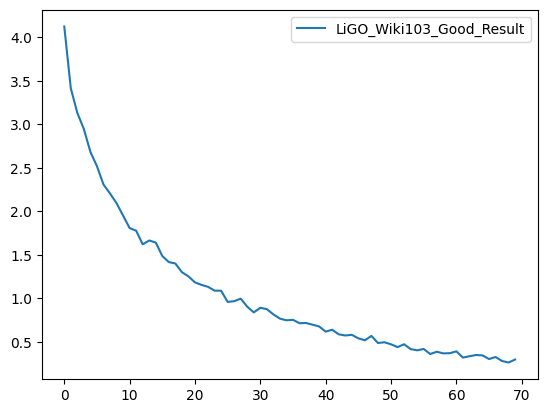

In [46]:
import pandas as pd, matplotlib.pyplot as plt

df = pd.DataFrame({'LiGO_Wiki103_Good_Result': ligo_curve2})

df.plot()

df.to_pickle('LiGO_Wiki103_Good_Result.pkl')



### 3 Models

In [47]:
num_models = 3

In [48]:
# Calculate the split points
train_split_3 = len(train_dataset) // 3
train_split_2_3 = 2 * len(train_dataset) // 3
val_split_3 = len(val_dataset) // 3
val_split_2_3 = 2 * len(val_dataset) // 3

# Create subsets for each third
train_dataset_1_3 = Subset(train_dataset, range(train_split_3))
train_dataset_2_3 = Subset(train_dataset, range(train_split_3, train_split_2_3))
train_dataset_3_3 = Subset(train_dataset, range(train_split_2_3, len(train_dataset)))

val_dataset_1_3 = Subset(val_dataset, range(val_split_3))
val_dataset_2_3 = Subset(val_dataset, range(val_split_3, val_split_2_3))
val_dataset_3_3 = Subset(val_dataset, range(val_split_2_3, len(val_dataset)))

# Create DataLoaders for each third
train_dataloader_1_3 = DataLoader(train_dataset_1_3, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_2_3 = DataLoader(train_dataset_2_3, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_3_3 = DataLoader(train_dataset_3_3, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

val_dataloader_1_3 = DataLoader(val_dataset_1_3, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_2_3 = DataLoader(val_dataset_2_3, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_3_3 = DataLoader(val_dataset_3_3, shuffle=False, batch_size=batch_size, collate_fn=data_collator)

# Convert to lists if necessary
train_dataloader_1_3 = list(train_dataloader_1_3)
train_dataloader_2_3 = list(train_dataloader_2_3)
train_dataloader_3_3 = list(train_dataloader_3_3)

val_dataloader_1_3 = list(val_dataloader_1_3)
val_dataloader_2_3 = list(val_dataloader_2_3)
val_dataloader_3_3 = list(val_dataloader_3_3)

In [49]:
model3_1 = Model(4).to(device)
optimizer3_1 = torch.optim.Adam(model3_1.parameters(), lr=learning_rate)

model3_2 = Model(4).to(device)
optimizer3_2 = torch.optim.Adam(model3_2.parameters(), lr=learning_rate)

model3_3 = Model(4).to(device)
optimizer3_3 = torch.optim.Adam(model3_3.parameters(), lr=learning_rate)

In [50]:
train(model3_1, optimizer3_1, 30, train_dataloader_1_3, val_dataloader_1_3)
train(model3_2, optimizer3_2, 30, train_dataloader_2_3, val_dataloader_2_3)
train(model3_3, optimizer3_3, 30, train_dataloader_3_3, val_dataloader_3_3)

Epoch 1, Train Loss: 10.6325, Val Loss: 10.1310
Epoch 2, Train Loss: 9.9415, Val Loss: 9.5043
Epoch 3, Train Loss: 9.3621, Val Loss: 8.9145
Epoch 4, Train Loss: 8.8286, Val Loss: 8.4133
Epoch 5, Train Loss: 8.3173, Val Loss: 7.8815
Epoch 6, Train Loss: 7.8408, Val Loss: 7.3827
Epoch 7, Train Loss: 7.4202, Val Loss: 6.9598
Epoch 8, Train Loss: 7.0208, Val Loss: 6.6248
Epoch 9, Train Loss: 6.6646, Val Loss: 6.2700
Epoch 10, Train Loss: 6.3224, Val Loss: 5.9256
Epoch 11, Train Loss: 6.0550, Val Loss: 5.6770
Epoch 12, Train Loss: 5.7669, Val Loss: 5.4040
Epoch 13, Train Loss: 5.5195, Val Loss: 5.0950
Epoch 14, Train Loss: 5.3087, Val Loss: 4.9474
Epoch 15, Train Loss: 5.1076, Val Loss: 4.7451
Epoch 16, Train Loss: 4.9286, Val Loss: 4.4847
Epoch 17, Train Loss: 4.7390, Val Loss: 4.3536
Epoch 18, Train Loss: 4.5479, Val Loss: 4.2656
Epoch 19, Train Loss: 4.4055, Val Loss: 4.0380
Epoch 20, Train Loss: 4.2848, Val Loss: 3.8830
Epoch 21, Train Loss: 4.1278, Val Loss: 3.8408
Epoch 22, Train Loss

[10.155055046081543,
 9.52471752166748,
 8.914737129211426,
 8.348830604553223,
 7.918746566772461,
 7.361751079559326,
 6.968773651123047,
 6.619887733459473,
 6.260962772369385,
 5.879532051086426,
 5.6477861404418945,
 5.359693145751953,
 5.108252906799317,
 4.867738533020019,
 4.757624626159668,
 4.598983860015869,
 4.349385547637939,
 4.087892341613769,
 3.989275074005127,
 3.906986713409424,
 3.766357088088989,
 3.5758368015289306,
 3.4879847049713133,
 3.338698720932007,
 3.2524654388427736,
 3.0784919261932373,
 2.9222468376159667,
 2.85539026260376,
 2.7667691707611084,
 2.7793118953704834]

In [51]:
torch.save(model3_1.state_dict(), 'models/model_3_1.pth')
torch.save(model3_2.state_dict(), 'models/model_3_2.pth')
torch.save(model3_3.state_dict(), 'models/model_3_3.pth')

In [53]:
k_params = torch.empty((0,emb_size*emb_size)).to(device)
q_params = torch.empty((0,emb_size*emb_size)).to(device)
v_params = torch.empty((0,emb_size*emb_size)).to(device)
lin_params = torch.empty((0, 2*emb_size*emb_size)).to(device)
ffn_w_params = torch.empty((0, emb_size*emb_size)).to(device)
ffn_b_params = torch.empty((0, emb_size)).to(device)
l_norm_w_params = torch.empty((0, emb_size)).to(device)
l_norm_b_params = torch.empty((0, emb_size)).to(device)
emb_params = torch.cat((model3_1.embedding.weight.view(-1), model3_2.embedding.weight.view(-1), model3_3.embedding.weight.view(-1))).to(device).view(num_models, -1)
f_lin_w_params = torch.cat((model3_1.f_lin.weight.view(-1), model3_2.f_lin.weight.view(-1), model3_3.f_lin.weight.view(-1))).to(device).view(num_models,-1)
f_lin_b_params = torch.cat((model3_1.f_lin.bias, model3_2.f_lin.bias, model3_3.f_lin.bias)).to(device).view(num_models,-1)
for i in model3_1.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model3_1.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model3_1.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model3_1.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model3_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model3_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model3_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model3_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model3_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
for i in model3_2.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model3_2.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model3_2.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model3_2.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model3_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model3_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model3_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model3_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model3_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
for i in model3_3.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model3_3.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model3_3.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model3_3.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model3_3.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model3_3.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model3_3.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model3_3.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model3_3.state_dict()[i].flatten().view(1,-1)), dim = 0)

In [75]:
ligo3 = LiGO(12)
optim_l3 = torch.optim.Adam(params=ligo3.parameters(), lr=1e-2)
train(ligo3, optim_l3, 10, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 12.0379, Val Loss: 8.6454
Epoch 2, Train Loss: 8.8814, Val Loss: 8.4813
Epoch 3, Train Loss: 8.4689, Val Loss: 8.2995
Epoch 4, Train Loss: 8.2741, Val Loss: 8.1324
Epoch 5, Train Loss: 8.1830, Val Loss: 8.1481
Epoch 6, Train Loss: 8.1686, Val Loss: 8.0523
Epoch 7, Train Loss: 8.1352, Val Loss: 8.0787
Epoch 8, Train Loss: 8.0919, Val Loss: 7.9577
Epoch 9, Train Loss: 8.0470, Val Loss: 7.9991
Epoch 10, Train Loss: 8.0348, Val Loss: 7.9820


[8.645420265197753,
 8.481271553039551,
 8.299542808532715,
 8.132402420043945,
 8.148088645935058,
 8.05233974456787,
 8.078744697570801,
 7.957691287994384,
 7.999072265625,
 7.982003021240234]

In [69]:
bigModel3 = Model(12)
initLiGO(ligo3, bigModel3, 12)
optim_b3 = torch.optim.Adam(params = bigModel3.parameters(), lr=learning_rate)
ligo_curve3 = train(bigModel3, optim_b3, 70, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 8.0954, Val Loss: 7.9899
Epoch 2, Train Loss: 7.9916, Val Loss: 7.9145
Epoch 3, Train Loss: 7.9130, Val Loss: 7.8026
Epoch 4, Train Loss: 7.8340, Val Loss: 7.8095
Epoch 5, Train Loss: 7.7624, Val Loss: 7.5894
Epoch 6, Train Loss: 7.6986, Val Loss: 7.6397
Epoch 7, Train Loss: 7.6546, Val Loss: 7.5525
Epoch 8, Train Loss: 7.6181, Val Loss: 7.5404
Epoch 9, Train Loss: 7.5625, Val Loss: 7.4721
Epoch 10, Train Loss: 7.5417, Val Loss: 7.4615
Epoch 11, Train Loss: 7.5333, Val Loss: 7.4849
Epoch 12, Train Loss: 7.5096, Val Loss: 7.4181
Epoch 13, Train Loss: 7.4861, Val Loss: 7.4122
Epoch 14, Train Loss: 7.4907, Val Loss: 7.4437
Epoch 15, Train Loss: 7.4858, Val Loss: 7.3911
Epoch 16, Train Loss: 7.4783, Val Loss: 7.3895
Epoch 17, Train Loss: 7.4564, Val Loss: 7.4521
Epoch 18, Train Loss: 7.4728, Val Loss: 7.4189
Epoch 19, Train Loss: 7.4907, Val Loss: 7.4429
Epoch 20, Train Loss: 7.4605, Val Loss: 7.4266
Epoch 21, Train Loss: 7.4523, Val Loss: 7.3796
Epoch 22, Train Loss: 

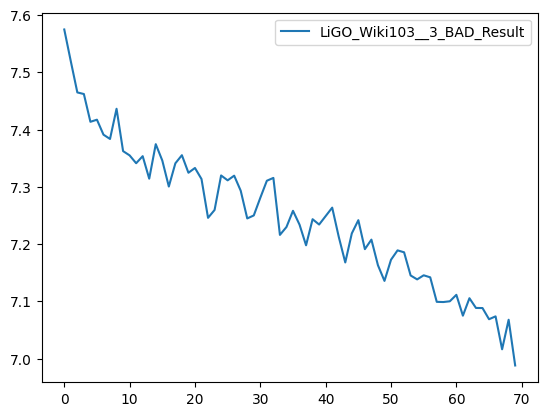

In [57]:

df2 = pd.DataFrame({'LiGO_Wiki103__3_BAD_Result': ligo_curve3})

df2.plot()

# df.to_pickle('LiGO_Wiki103_3_Bad_Result.pkl')

### 4 Models

In [37]:
num_models = 4

In [38]:
# Calculate the split points
train_split_1_4 = len(train_dataset) // 4
train_split_2_4 = 2 * len(train_dataset) // 4
train_split_3_4 = 3 * len(train_dataset) // 4

val_split_1_4 = len(val_dataset) // 4
val_split_2_4 = 2 * len(val_dataset) // 4
val_split_3_4 = 3 * len(val_dataset) // 4

# Create subsets for each quarter
train_dataset_1_4 = Subset(train_dataset, range(train_split_1_4))
train_dataset_2_4 = Subset(train_dataset, range(train_split_1_4, train_split_2_4))
train_dataset_3_4 = Subset(train_dataset, range(train_split_2_4, train_split_3_4))
train_dataset_4_4 = Subset(train_dataset, range(train_split_3_4, len(train_dataset)))

val_dataset_1_4 = Subset(val_dataset, range(val_split_1_4))
val_dataset_2_4 = Subset(val_dataset, range(val_split_1_4, val_split_2_4))
val_dataset_3_4 = Subset(val_dataset, range(val_split_2_4, val_split_3_4))
val_dataset_4_4 = Subset(val_dataset, range(val_split_3_4, len(val_dataset)))

# Create DataLoaders for each quarter
train_dataloader_1_4 = DataLoader(train_dataset_1_4, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_2_4 = DataLoader(train_dataset_2_4, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_3_4 = DataLoader(train_dataset_3_4, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
train_dataloader_4_4 = DataLoader(train_dataset_4_4, shuffle=True, batch_size=batch_size, collate_fn=data_collator)

val_dataloader_1_4 = DataLoader(val_dataset_1_4, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_2_4 = DataLoader(val_dataset_2_4, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_3_4 = DataLoader(val_dataset_3_4, shuffle=False, batch_size=batch_size, collate_fn=data_collator)
val_dataloader_4_4 = DataLoader(val_dataset_4_4, shuffle=False, batch_size=batch_size, collate_fn=data_collator)

# Convert to lists if necessary
train_dataloader_1_4 = list(train_dataloader_1_4)
train_dataloader_2_4 = list(train_dataloader_2_4)
train_dataloader_3_4 = list(train_dataloader_3_4)
train_dataloader_4_4 = list(train_dataloader_4_4)

val_dataloader_1_4 = list(val_dataloader_1_4)
val_dataloader_2_4 = list(val_dataloader_2_4)
val_dataloader_3_4 = list(val_dataloader_3_4)
val_dataloader_4_4 = list(val_dataloader_4_4)

In [39]:
model4_1 = Model(4).to(device)
optimizer4_1 = torch.optim.Adam(model4_1.parameters(), lr=learning_rate)

model4_2 = Model(4).to(device)
optimizer4_2 = torch.optim.Adam(model4_2.parameters(), lr=learning_rate)

model4_3 = Model(4).to(device)
optimizer4_3 = torch.optim.Adam(model4_3.parameters(), lr=learning_rate)

model4_4 = Model(4).to(device)
optimizer4_4 = torch.optim.Adam(model4_4.parameters(), lr=learning_rate)

In [40]:
train(model4_1, optimizer4_1, 30, train_dataloader_1_4, val_dataloader_1_4)
train(model4_2, optimizer4_2, 30, train_dataloader_2_4, val_dataloader_2_4)
train(model4_3, optimizer4_3, 30, train_dataloader_3_4, val_dataloader_3_4)
train(model4_4, optimizer4_4, 30, train_dataloader_4_4, val_dataloader_4_4)

Epoch 1, Train Loss: 10.5683, Val Loss: 9.9034
Epoch 2, Train Loss: 9.7947, Val Loss: 9.1451
Epoch 3, Train Loss: 9.1414, Val Loss: 8.4549
Epoch 4, Train Loss: 8.5152, Val Loss: 7.7702
Epoch 5, Train Loss: 7.9054, Val Loss: 7.1434
Epoch 6, Train Loss: 7.3445, Val Loss: 6.5390
Epoch 7, Train Loss: 6.8363, Val Loss: 6.0548
Epoch 8, Train Loss: 6.4248, Val Loss: 5.6570
Epoch 9, Train Loss: 5.9742, Val Loss: 5.2460
Epoch 10, Train Loss: 5.6135, Val Loss: 4.9037
Epoch 11, Train Loss: 5.3395, Val Loss: 4.6026
Epoch 12, Train Loss: 5.0353, Val Loss: 4.3405
Epoch 13, Train Loss: 4.7968, Val Loss: 4.1364
Epoch 14, Train Loss: 4.5622, Val Loss: 3.8900
Epoch 15, Train Loss: 4.3469, Val Loss: 3.7127
Epoch 16, Train Loss: 4.1677, Val Loss: 3.5767
Epoch 17, Train Loss: 4.0274, Val Loss: 3.3817
Epoch 18, Train Loss: 3.8602, Val Loss: 3.2862
Epoch 19, Train Loss: 3.6872, Val Loss: 3.1333
Epoch 20, Train Loss: 3.5384, Val Loss: 3.0088
Epoch 21, Train Loss: 3.4090, Val Loss: 2.9115
Epoch 22, Train Loss:

[9.891694450378418,
 9.126509857177734,
 8.310210800170898,
 7.684473037719727,
 7.065535068511963,
 6.4561258316040036,
 5.9683795928955075,
 5.536582946777344,
 5.226312255859375,
 4.831785774230957,
 4.638123416900635,
 4.354479217529297,
 4.080842685699463,
 3.9617868423461915,
 3.733758783340454,
 3.597694444656372,
 3.431184434890747,
 3.3146644115447996,
 3.187332582473755,
 3.068721628189087,
 2.96297287940979,
 2.833140754699707,
 2.7382453441619874,
 2.6311426162719727,
 2.540710115432739,
 2.4394567012786865,
 2.3540946006774903,
 2.268109083175659,
 2.1882665157318115,
 2.1161124229431154]

In [41]:
k_params = torch.empty((0,emb_size*emb_size)).to(device)
q_params = torch.empty((0,emb_size*emb_size)).to(device)
v_params = torch.empty((0,emb_size*emb_size)).to(device)
lin_params = torch.empty((0, 2*emb_size*emb_size)).to(device)
ffn_w_params = torch.empty((0, emb_size*emb_size)).to(device)
ffn_b_params = torch.empty((0, emb_size)).to(device)
l_norm_w_params = torch.empty((0, emb_size)).to(device)
l_norm_b_params = torch.empty((0, emb_size)).to(device)
emb_params = torch.cat((model4_1.embedding.weight.view(-1), model4_2.embedding.weight.view(-1), model4_3.embedding.weight.view(-1), model4_4.embedding.weight.view(-1))).to(device).view(num_models, -1)
f_lin_w_params = torch.cat((model4_1.f_lin.weight.view(-1), model4_2.f_lin.weight.view(-1), model4_3.f_lin.weight.view(-1), model4_4.f_lin.weight.view(-1))).to(device).view(num_models,-1)
f_lin_b_params = torch.cat((model4_1.f_lin.bias, model4_2.f_lin.bias, model4_3.f_lin.bias, model4_4.f_lin.bias)).to(device).view(num_models,-1)
for i in model4_1.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model4_1.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model4_1.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model4_1.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model4_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model4_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model4_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model4_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model4_1.state_dict()[i].flatten().view(1,-1)), dim = 0)
for i in model4_2.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model4_2.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model4_2.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model4_2.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model4_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model4_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model4_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model4_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model4_2.state_dict()[i].flatten().view(1,-1)), dim = 0)
for i in model4_3.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model4_3.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model4_3.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model4_3.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model4_3.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model4_3.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model4_3.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model4_3.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model4_3.state_dict()[i].flatten().view(1,-1)), dim = 0)
for i in model4_4.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model4_4.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model4_4.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model4_4.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model4_4.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model4_4.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model4_4.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model4_4.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model4_4.state_dict()[i].flatten().view(1,-1)), dim = 0)

In [42]:
ligo4 = LiGO(16)
optim_l4 = torch.optim.Adam(params=ligo4.parameters(), lr=1e-2)
train(ligo4, optim_l4, 10, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 22.0585, Val Loss: 12.8338
Epoch 2, Train Loss: 11.1729, Val Loss: 8.6060
Epoch 3, Train Loss: 8.8011, Val Loss: 8.4590
Epoch 4, Train Loss: 8.3764, Val Loss: 7.6649
Epoch 5, Train Loss: 8.0669, Val Loss: 7.5690
Epoch 6, Train Loss: 7.9146, Val Loss: 7.5820
Epoch 7, Train Loss: 7.8761, Val Loss: 7.4859
Epoch 8, Train Loss: 7.8352, Val Loss: 7.4403
Epoch 9, Train Loss: 7.7971, Val Loss: 7.4020
Epoch 10, Train Loss: 7.7878, Val Loss: 7.4016


[12.833756828308106,
 8.605983924865722,
 8.459004020690918,
 7.664882469177246,
 7.569046115875244,
 7.581994819641113,
 7.485889720916748,
 7.440293788909912,
 7.4019674301147464,
 7.401582336425781]

In [43]:
bigModel4 = Model(16)
initLiGO(ligo4, bigModel4,16)
optim_b4 = torch.optim.Adam(params = bigModel4.parameters(), lr=learning_rate)
ligo_curve4 = train(bigModel4, optim_b4, 70, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

Epoch 1, Train Loss: 7.6175, Val Loss: 7.0476
Epoch 2, Train Loss: 7.4078, Val Loss: 6.8819
Epoch 3, Train Loss: 7.2771, Val Loss: 6.7572
Epoch 4, Train Loss: 7.2080, Val Loss: 6.7448
Epoch 5, Train Loss: 7.1759, Val Loss: 6.6891
Epoch 6, Train Loss: 7.1484, Val Loss: 6.6506
Epoch 7, Train Loss: 7.1019, Val Loss: 6.6508
Epoch 8, Train Loss: 7.0976, Val Loss: 6.5593
Epoch 9, Train Loss: 7.0803, Val Loss: 6.6205
Epoch 10, Train Loss: 7.0887, Val Loss: 6.6218
Epoch 11, Train Loss: 7.0785, Val Loss: 6.5909
Epoch 12, Train Loss: 7.0794, Val Loss: 6.6251
Epoch 13, Train Loss: 7.0554, Val Loss: 6.5582
Epoch 14, Train Loss: 7.0530, Val Loss: 6.6530
Epoch 15, Train Loss: 7.0519, Val Loss: 6.5457
Epoch 16, Train Loss: 7.0427, Val Loss: 6.5584
Epoch 17, Train Loss: 7.0306, Val Loss: 6.5373
Epoch 18, Train Loss: 7.0451, Val Loss: 6.5419
Epoch 19, Train Loss: 7.0241, Val Loss: 6.6476
Epoch 20, Train Loss: 7.0521, Val Loss: 6.5945
Epoch 21, Train Loss: 7.0371, Val Loss: 6.5614
Epoch 22, Train Loss: 

In [44]:
sample = None
for i in train_dataloader:
    sample = i['input_ids']
    break

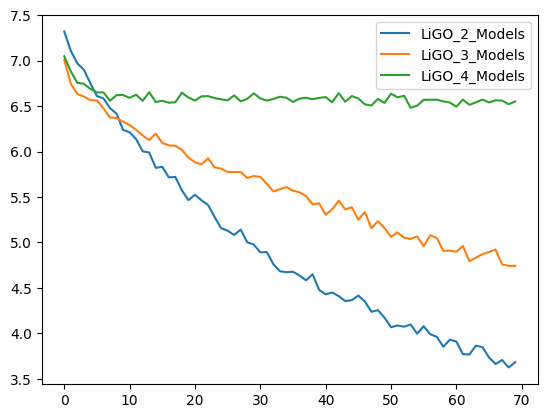

In [45]:
import pandas as pd, matplotlib as plt

df = pd.DataFrame({'LiGO_2_Models':ligo_curve2, 'LiGO_3_Models':ligo_curve3, 'LiGO_4_Models':ligo_curve4})

df.plot()

df.to_pickle('Wiki103_3_model_LiGO')